In [61]:
import pandas as pd
import numpy as np
import glob
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
adhd_files = glob.glob("adhd/*.json")
nonadhd_files = glob.glob("nonadhd/*.json")

for file in adhd_files + nonadhd_files:
    with open(file, "r") as f:
        data = json.load(f)
    df = pd.json_normalize(data, record_path="trials")
    csv_path = file.replace(".json", ".csv")
    df.to_csv(csv_path, index=False)

adhd_csvs = glob.glob("adhd/*.csv")
nonadhd_csvs = glob.glob("nonadhd/*.csv")

adhd_dfs = [pd.read_csv(f) for f in adhd_csvs]
nonadhd_dfs = [pd.read_csv(f) for f in nonadhd_csvs]

adhd_cpt = pd.concat(adhd_dfs, ignore_index=True)
adhd_cpt["Group"] = "ADHD"

nonadhd_cpt = pd.concat(nonadhd_dfs, ignore_index=True)
nonadhd_cpt["Group"] = "Neurotypical"

combined_cpts = pd.concat([adhd_cpt, nonadhd_cpt], ignore_index=True)


In [73]:
#Calculate Averages across each group
group_means = combined_cpts.groupby("Group").mean(numeric_only=True)

#Calculate the Standard deviation across each group
group_stds = combined_cpts.groupby("Group").std(numeric_only=True)

#Calculate deltas
mean_deltas = group_means.loc["ADHD"] - group_means.loc["Neurotypical"]
std_deltas = group_stds.loc["ADHD"] - group_stds.loc["Neurotypical"]
#Build summary table
summary = pd.DataFrame ({
    "ADHD_Mean": group_means.loc["ADHD"],
    "ADHD_SD": group_stds.loc["ADHD"],
    "Neurotypical_Mean": group_means.loc["Neurotypical"],
    "Neurotypical_SD": group_stds.loc["Neurotypical"],
    "Mean_Delta": mean_deltas,
    "SD_Delta": std_deltas,
})


#Calcualte Z-Scores
valid_mask = (combined_cpts["is_hit"] == 1) | (combined_cpts["is_commission"] == 1)
valid_rts = combined_cpts.loc[valid_mask, "response_time_ms"]

mu = valid_rts.mean()
sigma = valid_rts.std(ddof=0)

combined_cpts["response_time_z"] = np.where(
    valid_mask,
    (combined_cpts["response_time_ms"] - mu) / sigma,
    np.nan  # leave omissions as NaN
)
rt_data = combined_cpts.loc[combined_cpts["response_time_z"].notna()]
rt_data_mean = rt_data.groupby("Group")["response_time_z"].mean()
rt_data_mean




Group
ADHD            0.510518
Neurotypical   -0.408415
Name: response_time_z, dtype: float64

In [64]:
#Export
summary.to_csv("CPT_Summary.csv")


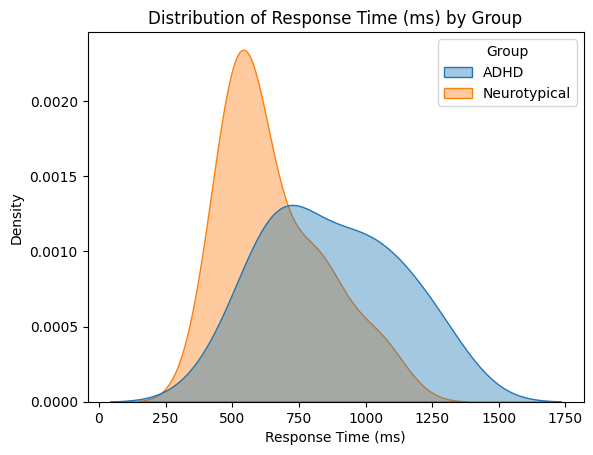

In [65]:
# Bell curve for response time
sns.kdeplot(
    data=combined_cpts,
    x="response_time_ms",
    hue="Group",
    fill=True,
    common_norm=False,
    alpha=0.4,
)

plt.title("Distribution of Response Time (ms) by Group")
plt.xlabel("Response Time (ms)")
plt.ylabel("Density")
plt.savefig("fig.png", dpi=300)

